# Single Peak Simulations

In this set of simulations, we will test power spectrum parameterization performance on power spectra simulated with a single peak. We will compare the results given by our method and the original SpecParam algorithm proposed by Donoghue et al.

This simulation test checks the use case of identifying and quantifying the dominant peak in a power spectrum.

To do so, we will simulate power spectra with a single peak with an aperiodic component in 'fixed' mode, all with varying parameters.

Performance will be evaluated by examining how well the algorithms can reconstruct periodic and aperiodic parameters for the simulated power spectra.

In [1]:
%matplotlib inline

In [2]:
from os.path import join as pjoin

import numpy as np
from scipy.stats import spearmanr

from fooof import FOOOFGroup, fit_fooof_3d
from fooof.sim import gen_group_power_spectra
from fooof.sim.utils import set_random_seed

In [3]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from plts import *
from sims import *
from utils import *
from analysis import *
from settings import *

In [4]:
import warnings
import os
from numpy.linalg import LinAlgError
from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import time
import datetime
import copy
import argparse
import fooof
import math
from parameterize_spectra import *
from joblib import Parallel, delayed

## Settings

In [5]:
# Set random seed
set_random_seed(303)

In [6]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [7]:
# Set a folder name (for saving data & figures)
FOLDER = '01_one-peak/'

In [8]:
# Data & Model Setting
GEN_SIMS = False
SAVE_SIMS = False
FIT_MODELS = False
SAVE_MODELS = False
SAVE_GTH = False

RUN_OUR_METHOD = True
SAVE_OUR_MODEL = True

In [9]:
# Run Settings
SAVE_FIG = True
PLT_LOG = True

# If not plotting in log, turn off log-defined plot limits
if not PLT_LOG:
    YLIMS_AP = YLIMS_KN = YLIMS_CF = YLIMS_PW = YLIMS_BW = None
    YTICKS_CF = YTICKS_PW = YTICKS_BW = None
    YTICKS_FE = None

In [10]:
# Check the conditions to simulate across: noise level
print('NLVS: ', NLVS)

NLVS:  [0.0, 0.025, 0.05, 0.1, 0.15]


In [11]:
# Set the number of power spectra (per condition)
n_psds = N_PSDS

## Simulation Tests: One Peak Across Noise Levels

First, simulate power spectra with one peak, and measure how well each of the methods can reconstruct each variable.

### Simulate Power Spectra

In [12]:
# Use generators to sample peak & aperiodic parameters
peaks = gen_peak_def(1)
aps = gen_ap_def()

print('Peaks: \n', peaks)

Peaks: 
 <generator object gen_peak_def at 0x7fa270ec2ac0>


In [13]:
# Get data sizes
n_conds = len(NLVS)
n_freqs = int((F_RANGE[1] - F_RANGE[0]) / F_RES + 1)

In [14]:
# Generate or load power spectra
data_name = 'single_peak_sims'

if GEN_SIMS:
    
    # Initialize data stores
    psds = np.empty(shape=[n_conds, n_psds, n_freqs])
    sim_params = [None] * n_conds

    # Generate simulated power spectra
    for n_ind, nlv in enumerate(NLVS):
        freqs, psds[n_ind, :, :], sim_params[n_ind] = \
            gen_group_power_spectra(n_psds, F_RANGE, aps, peaks, nlv,
                                    F_RES, return_params=True)
    
    # Save out generated simulated data & parameter definitions
    if SAVE_SIMS:
        save_sim_data(data_name, FOLDER, freqs, psds, sim_params)

else:
    # Reload simulated data and parameter definitions
    freqs, psds, sim_params = load_sim_data(data_name, FOLDER)
    
# Check shape
print('n_conds, n_spectra, n_freqs : ', psds.shape)

n_conds, n_spectra, n_freqs :  (5, 1000, 153)


In [15]:
# Extract ground truth values
peak_truths, ap_truths = get_ground_truth(sim_params)

# Save out ground truth values - added by AT
if SAVE_GTH:
    save_ground_truth(data_name, FOLDER, peak_truths, ap_truths)

print('Peak Truths: \n', peak_truths.shape)
print('AP Truths: \n', ap_truths.shape)

Peak Truths: 
 (5, 1000, 3)
AP Truths: 
 (5, 1000, 2)


##### Check the empirical levels of noise expected  (empirical noise floor)

The empirical noise levels should be the same as the noise scaling factor set in the simulations.

This is just a check, to estimate the actual error off the simulations. 

Note that the noise values also determine the amount of variance that can be expected to be captured by fitting.

If parameterization captures more variance than expected given the amount of simulated noise, this suggests the algorithm is overfitting. 

In [16]:
emp_nlv = []
for nlv in NLVS:
    temp = []

    # Within each noise level, get the average squared 'error'
    for it in range(n_psds):
        temp.append(np.mean(np.random.normal(0, nlv, len(freqs))**2))
    
    # Get the average 'error' per noise level
    emp_nlv.append(np.mean(temp))

In [17]:
# Compare simulated values to empirical values
print('Simulated NLV Values:')
print_list(NLVS)
print('Empirical NLV Values:')
print_list(np.sqrt(emp_nlv))

Simulated NLV Values:
['0.0000', '0.0250', '0.0500', '0.1000', '0.1500']
Empirical NLV Values:
['0.0000', '0.0250', '0.0500', '0.0999', '0.1501']


### Fit Power Spectra with FOOOF (SpecParam)

In [18]:
# Initialize FOOOFGroup to test with
fg_SpecParam = FOOOFGroup(*FOOOF_SETTINGS, verbose=False)

# Print out settings used for fitting simulated power spectra
fg_SpecParam.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 8]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.1                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : fixed                                      
                                                                                                  


In [19]:
# Fit power spectra
if FIT_MODELS:
    fgs_SpecParam = fit_fooof_3d(fg_SpecParam, freqs, psds)
    
    if SAVE_MODELS:
        save_model_data(data_name, FOLDER, fgs_SpecParam)
            
else:
    # Reload model fit data
    fgs_SpecParam = load_model_data(data_name, FOLDER, n_conds)

In [20]:
All_new_fg = []
for cond, fg in enumerate(fgs_SpecParam):
    new_fg = fg.copy()
    print('Condition : ', NLVS[cond])
    results_cond = new_fg.get_results()
    for ind, res in enumerate(results_cond):
        peak_params_ind_cond = res.peak_params
        gaussian_params_ind_cond = res.gaussian_params
        if len(peak_params_ind_cond)==0:
            print('No peaks found')  

Condition :  0.0
No peaks found
No peaks found
No peaks found
No peaks found
No peaks found
No peaks found
No peaks found
No peaks found
No peaks found
Condition :  0.025
No peaks found
Condition :  0.05
Condition :  0.1
Condition :  0.15


### Extract FOOOF fit Data

In [21]:
# Extract data of interest from FOOOF fits
peak_fits_SpecParam, ap_fits_SpecParam, err_fits_SpecParam, r2_fits_SpecParam, n_fit_peaks_SpecParam = get_fit_data(fgs_SpecParam)

In [22]:
print('Peak Fit Results:')
print(peak_fits_SpecParam.shape)
print(ap_fits_SpecParam.shape)
print(err_fits_SpecParam.shape)
print(r2_fits_SpecParam.shape)

Peak Fit Results:
(5, 1000, 3)
(5, 1000, 2)
(5, 1000)
(5, 1000)


In [23]:
# Calculate errors
peak_errors_SpecParam = calc_errors(peak_truths, peak_fits_SpecParam)
ap_errors_SpecParam = calc_errors(ap_truths, ap_fits_SpecParam)

In [24]:
# Pull out error per peak parameter
cf_errors_SpecParam = peak_errors_SpecParam[:, :, 0]
pw_errors_SpecParam = peak_errors_SpecParam[:, :, 1]
bw_errors_SpecParam = peak_errors_SpecParam[:, :, 2]

# Pull out error per aperiodic parameter
off_errors_SpecParam = ap_errors_SpecParam[:, :, 0]
exp_errors_SpecParam = ap_errors_SpecParam[:, :, 1]

### Check Average Errors & Stats

In [25]:
# Check overall fit quality
temp = r2_fits_SpecParam.flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.nanmin(temp), np.nanmax(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.nanmedian(temp)))

Min/Max R^2: 	0.3761 	1.0000
Median  R^2: 	0.9810


In [26]:
# Collect data together
datas_SpecParam = {
    'CF' : cf_errors_SpecParam,
    'PW' : pw_errors_SpecParam,
    'BW' : bw_errors_SpecParam,
    'OFF' : off_errors_SpecParam,
    'EXP' : exp_errors_SpecParam,
    'ERR' : err_fits_SpecParam,
    'R^2' : r2_fits_SpecParam
}

In [27]:
# Print out the average error for each parameter
#   Also prints out the average model error and R^2 per noise level
with np.printoptions(precision=4, suppress=True):
    for label, data in datas_SpecParam.items():
        print(label, '\n\t', np.nanmedian(data, 1))

CF 
	 [0.0044 0.103  0.3735 0.6927 1.1087]
PW 
	 [0.0025 0.0107 0.0249 0.0481 0.0922]
BW 
	 [0.0398 0.1341 0.5    1.0468 1.1244]
OFF 
	 [0.0013 0.0089 0.0239 0.0504 0.0781]
EXP 
	 [0.0011 0.0069 0.0207 0.0395 0.0627]
ERR 
	 [0.0012 0.0198 0.0383 0.0767 0.1158]
R^2 
	 [1.     0.9964 0.9877 0.9523 0.8989]


In [28]:
# Check if the amount of error correlates with the noise level
print('Correlations of median error with noise level:')
print('\n\t\t  r-val\t\tp-val')
print('\tCF\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(cf_errors_SpecParam, axis=1))))
print('\tPW\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(pw_errors_SpecParam, axis=1))))
print('\tBW\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(bw_errors_SpecParam, axis=1))))
print('\tOFF\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(off_errors_SpecParam, axis=1))))
print('\tEXP\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(exp_errors_SpecParam, axis=1))))

Correlations of median error with noise level:

		  r-val		p-val
	CF	: 1.000 	0.00
	PW	: 1.000 	0.00
	BW	: 1.000 	0.00
	OFF	: 1.000 	0.00
	EXP	: 1.000 	0.00


In the correlations above, we can see that, as expected the amount of error in the model fit correlates with the noise level of the simulated power spectra.

### Create Plots

#### Periodic Components

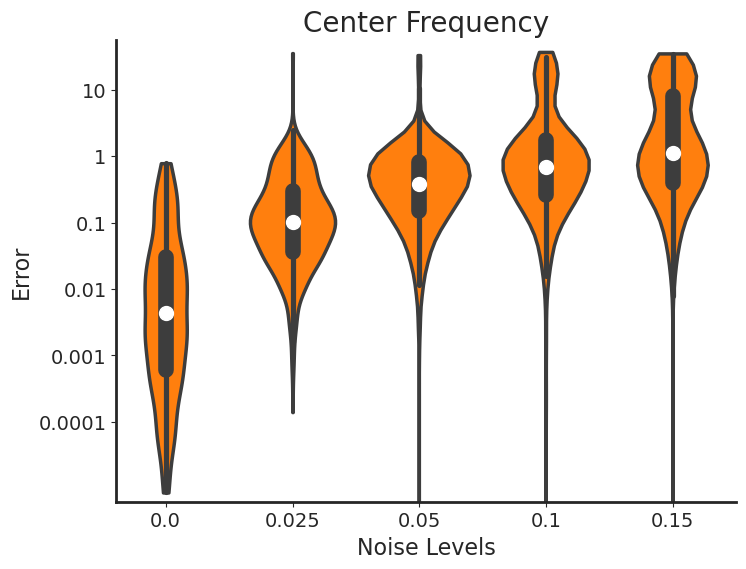

In [29]:
# Plot the error of peak center frequency reconstruction
plot_errors_violin(cf_errors_SpecParam, 'Center Frequency', plt_log=PLT_LOG, 
                   ylim=YLIMS_CF, yticks=YTICKS_CF,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'cf_error'), ifOrange=True)

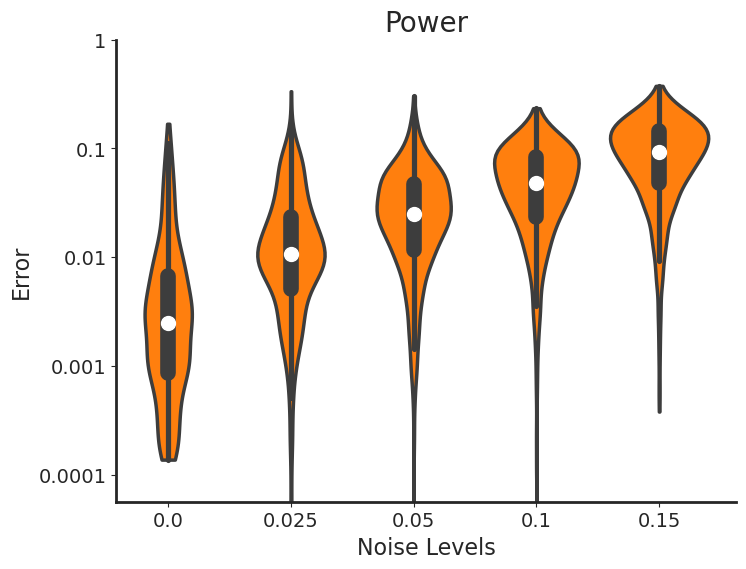

In [30]:
# Plot the error of peak power reconstruction
plot_errors_violin(pw_errors_SpecParam, 'Power', plt_log=PLT_LOG, 
                   ylim=YLIMS_PW, yticks=YTICKS_PW,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'pw_error'), ifOrange=True)

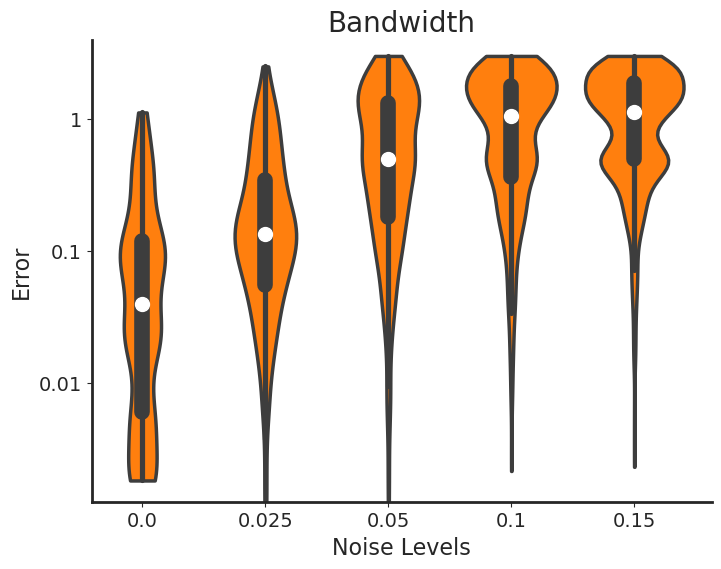

In [31]:
# Plot the error of peak bandwidth reconstruction
plot_errors_violin(bw_errors_SpecParam, 'Bandwidth', plt_log=PLT_LOG,
                   ylim=YLIMS_BW, yticks=YTICKS_BW,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'bw_error'), ifOrange=True)

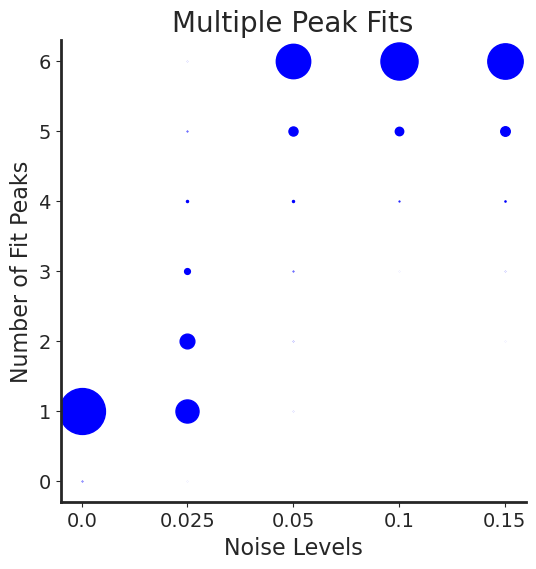

In [32]:
# Plot the number of peaks fit per condition
n_peak_counter = count_peak_conditions(n_fit_peaks_SpecParam, NLVS)
plot_n_peaks_bubbles(n_peak_counter, ms_val=15, x_label='nlvs')

#### Aperiodic Components

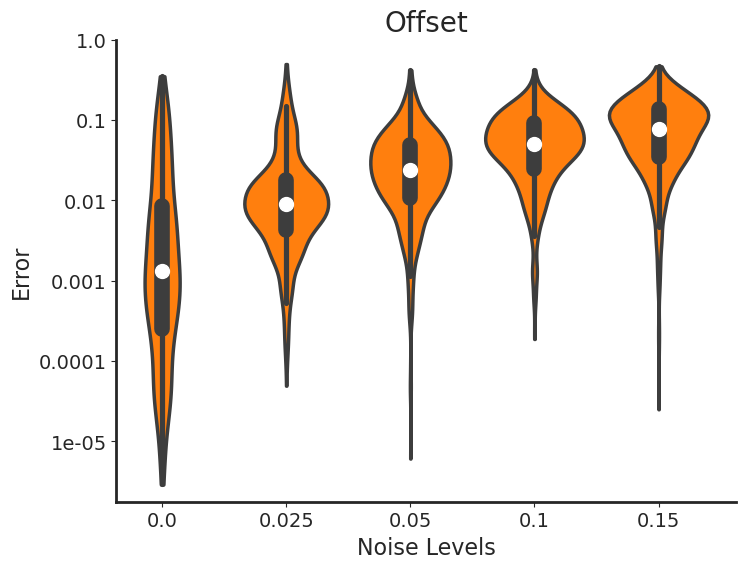

In [33]:
# Plot the error of aperiodic offset reconstruction
plot_errors_violin(off_errors_SpecParam, 'Offset', plt_log=PLT_LOG, ylim=YLIMS_AP,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'off_error'), ifOrange=True)

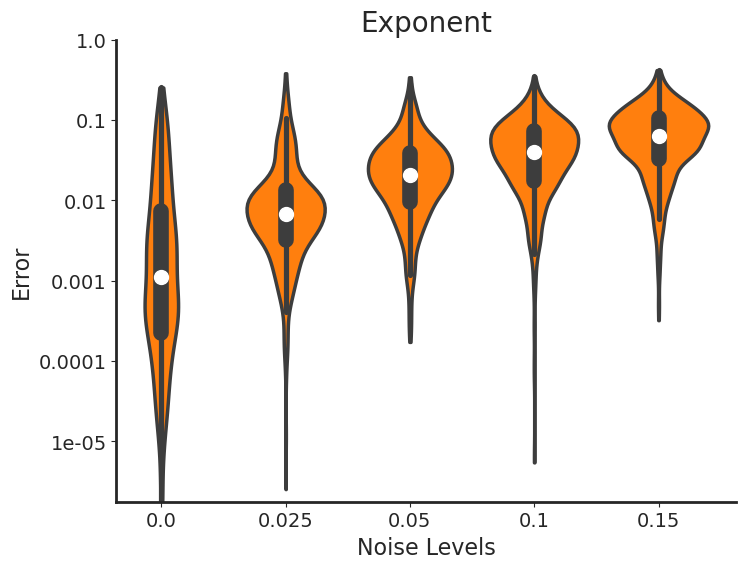

In [34]:
# Plot the error of aperiodic exponent reconstruction
plot_errors_violin(exp_errors_SpecParam, 'Exponent', plt_log=PLT_LOG, ylim=YLIMS_AP,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'exp_error'), ifOrange=True)

#### Goodness of Fit Measures

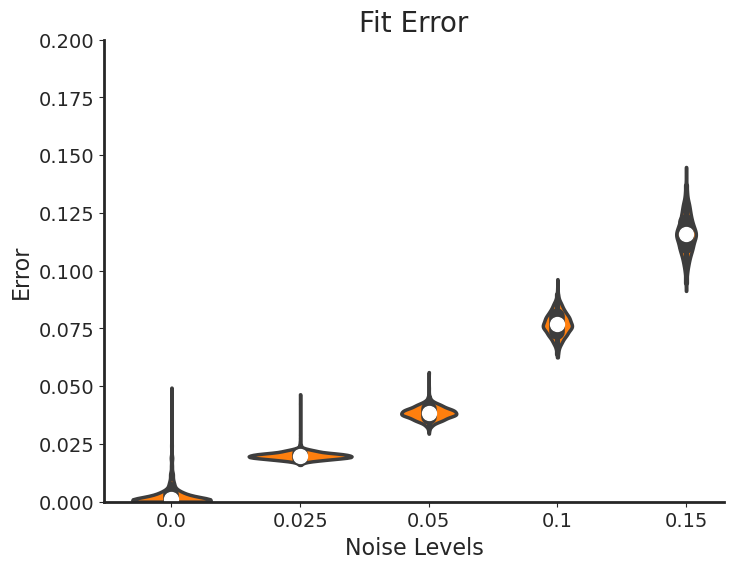

In [35]:
# Plot the amount of error across noise levels
plot_errors_violin(err_fits_SpecParam, 'Fit Error', y_label='Error', plt_log=False, ylim=[0, 0.2],
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'model_error'), ifOrange=True)

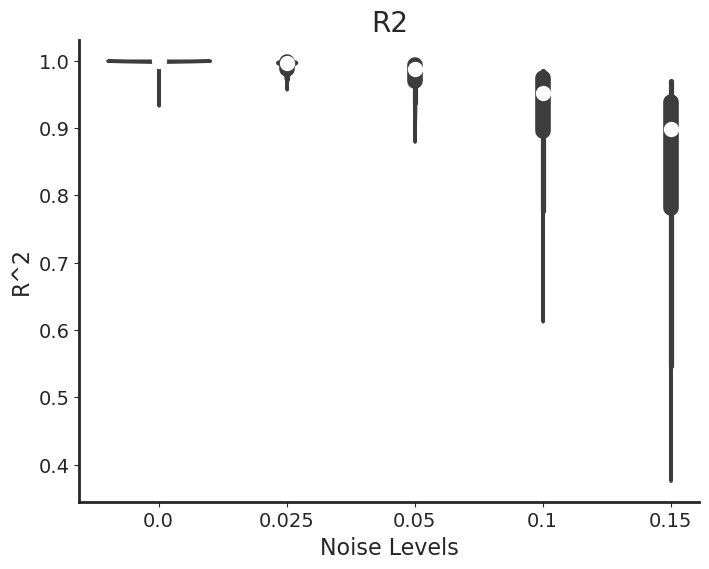

In [36]:
# Plot the goodness-of-fit (R^2) across noise levels
plot_errors_violin(r2_fits_SpecParam, 'R2', y_label='R^2', plt_log=False,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'model_r_squared'), ifOrange=True)

### Fit Power Spectra with Our method

This part is just for testing our algorithm on a sample psd!

(153,)
(153,)
peak truths: [28.   0.2  3. ]
Using bands: [(1.9999999999999998, 39.99999999999999)] to fit
Fit aperiodic component with knee mode
Peak 0: CF: 27.657118585457713, PW: 0.201699847588796, BW: 1.230155018912632
{'aperiodic_params': array([6.41024632e-03, 4.47731938e-08, 5.03777020e-01]), 'gaussian_params': array([0.05239109, 3.31988315, 0.1035701 ]), 'noise_pks': array([], dtype=float64), 'noise_wids': array([], dtype=float64), 'peak_params': array([3.31988315, 0.20169985, 0.20714019]), 'r_squared': 0.9663227163281537, 'error': 0.027013385947623952}


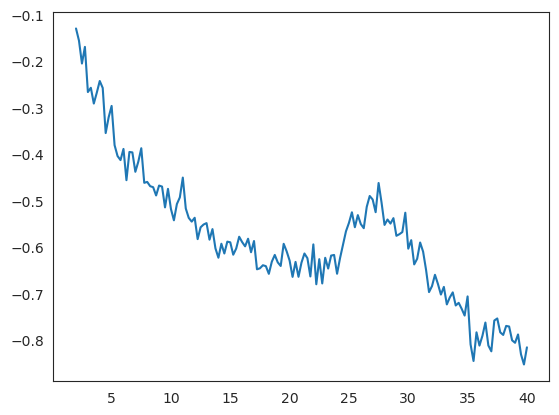

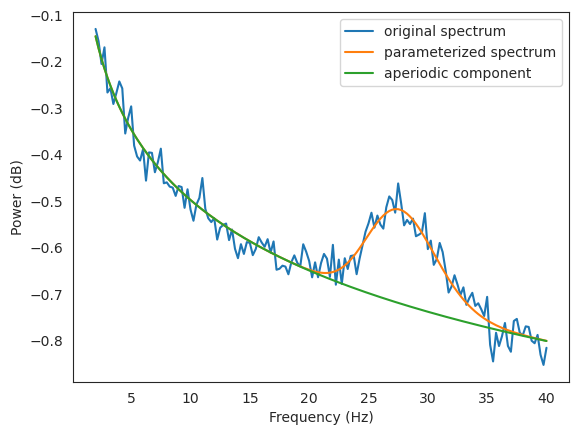

In [37]:
power_spectrum_test = psds[1, 300, :] # take the first trial
print(power_spectrum_test.shape)
print(freqs.shape)

print('peak truths:', peak_truths[1, 300,:])

# plot the power spectrum
plt.figure()
plt.plot(freqs, np.log10(power_spectrum_test))

param_spectra_test = ParamSpectra(bands='log',  max_n_peaks=1, log_freqs=True, n_division=1, l_freq=2, h_freq=40, prominence=0.5, linenoise=60, aperiodic_mode='knee', verbose=1)

param_spectra_test.fit(freqs, power_spectrum_test)
output_params_test = param_spectra_test.get_params_out()
print(output_params_test)

plt.figure()
plt.plot(freqs, np.log10(power_spectrum_test), label='original spectrum')
plt.plot(freqs, param_spectra_test.modeled_spectrum_, label='parameterized spectrum')
plt.plot(freqs, param_spectra_test._ap_fit, label='aperiodic component')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.show()

Now, let's apply our method on the whole simulated data.

In [38]:
print(psds.shape)

if RUN_OUR_METHOD:
    # define arrays to store the output parameters: aperiodic_params, peak_params, r_squared, error
    aperiodic_params_all_ourMethod = np.zeros((psds.shape[0], psds.shape[1], 3))
    peak_params_all_ourMethod = np.zeros((psds.shape[0], psds.shape[1], 3))
    r_squared_all_ourMethod = np.zeros((psds.shape[0], psds.shape[1]))
    error_all_ourMethod = np.zeros((psds.shape[0], psds.shape[1]))

    # fit and find the parameters
    for noise_lvl in range(psds.shape[0]):
        for trial in range(psds.shape[1]):
            param_spectra = ParamSpectra(bands='log',  max_n_peaks=1, log_freqs=True, n_division=1, l_freq=2, h_freq=40, prominence=0.5, linenoise=60, aperiodic_mode='knee', verbose=1)
            power_spectrum_trial = psds[noise_lvl, trial, :]
            param_spectra.fit(freqs, power_spectrum_trial)
            output_params = param_spectra.get_params_out()

            aperiodic_params = output_params['aperiodic_params']
            peak_params = output_params['peak_params']
            
            # reshape peak_params to be 3 columns
            peak_params = peak_params.reshape(-1, 3)

            # peak the row with highes =t value in second column
            peak_params = peak_params[np.argmax(peak_params[:, 1]), :]
            # bring the values of peakparams to linear scale
            peak_params[0] = np.exp(peak_params[0])
            peak_params[2] = np.exp(peak_params[2])

            r_squared = output_params['r_squared']
            error = output_params['error']
            
            # storing the output parameters
            aperiodic_params_all_ourMethod[noise_lvl, trial, :] = aperiodic_params
            peak_params_all_ourMethod[noise_lvl, trial, :] = peak_params
            r_squared_all_ourMethod[noise_lvl, trial] = r_squared
            error_all_ourMethod[noise_lvl, trial] = error
        print('Fitting with noise level:', {noise_lvl})

    # save the output parameters
    if SAVE_OUR_MODEL:
        np.save('../data/01_one-peak/aperiodic_params_all_ourMethod.npy', aperiodic_params_all_ourMethod)
        np.save('../data/01_one-peak/peak_params_all_ourMethod.npy', peak_params_all_ourMethod)
        np.save('../data/01_one-peak/r_squared_all_ourMethod.npy', r_squared_all_ourMethod)
        np.save('../data/01_one-peak/error_all_ourMethod.npy', error_all_ourMethod)

else:
    # load the output parameters saved before
    aperiodic_params_all_ourMethod = np.load('../data/01_one-peak/aperiodic_params_all_ourMethod.npy')
    peak_params_all_ourMethod = np.load('../data/01_one-peak/peak_params_all_ourMethod.npy')
    r_squared_all_ourMethod = np.load('../data/01_one-peak/r_squared_all_ourMethod.npy')
    error_all_ourMethod = np.load('../data/01_one-peak/error_all_ourMethod.npy')


(5, 1000, 153)
Using bands: [(1.9999999999999998, 39.99999999999999)] to fit
Fit aperiodic component with knee mode
Peak 0: CF: 15.849380057671288, PW: 0.3855912749598307, BW: 1.2657037078391287
Using bands: [(1.9999999999999998, 39.99999999999999)] to fit
Fit aperiodic component with knee mode
Peak 0: CF: 17.958999561767513, PW: 0.24932507015835959, BW: 1.1169984218829252
Using bands: [(1.9999999999999998, 39.99999999999999)] to fit
Fit aperiodic component with knee mode
Peak 0: CF: 8.947275196496488, PW: 0.283342937096116, BW: 1.577432084847819
Using bands: [(1.9999999999999998, 39.99999999999999)] to fit
Fit aperiodic component with knee mode
Peak 0: CF: 24.732248525224247, PW: 0.14630287149900534, BW: 1.2563500745528968
Using bands: [(1.9999999999999998, 39.99999999999999)] to fit
Fit aperiodic component with knee mode
Peak 0: CF: 10.79958334873469, PW: 0.1380534970492936, BW: 1.3806559215986063
Using bands: [(1.9999999999999998, 39.99999999999999)] to fit
Fit aperiodic component w

In [39]:
print(aperiodic_params_all_ourMethod.shape)
# throw away the column 1 of aperiodic_params_all (knee)
aperiodic_params_all_ourMethod = np.delete(aperiodic_params_all_ourMethod, 1, axis=2)
print(aperiodic_params_all_ourMethod.shape)
peak_fits_ourMethod = peak_params_all_ourMethod
ap_fits_ourMethod = aperiodic_params_all_ourMethod
r2_fits_ourMethod = r_squared_all_ourMethod
err_fits_ourMethod = error_all_ourMethod


print('Peak Fit Results using our methods:')
print(peak_fits_ourMethod.shape)
print(ap_fits_ourMethod.shape)
print(err_fits_ourMethod.shape)
print(r2_fits_ourMethod.shape)

(5, 1000, 3)
(5, 1000, 2)
Peak Fit Results using our methods:
(5, 1000, 3)
(5, 1000, 2)
(5, 1000)
(5, 1000)


In [40]:
# Calculate errors
peak_errors_ourMethod = calc_errors(peak_truths, peak_fits_ourMethod)
ap_errors_ourMethod = calc_errors(ap_truths, ap_fits_ourMethod)

In [41]:
# Pull out error per peak parameter
cf_errors_ourMethod = peak_errors_ourMethod[:, :, 0]
pw_errors_ourMethod = peak_errors_ourMethod[:, :, 1]
bw_errors_ourMethod = peak_errors_ourMethod[:, :, 2]

# Pull out error per aperiodic parameter
off_errors_ourMethod = ap_errors_ourMethod[:, :, 0]
exp_errors_ourMethod = ap_errors_ourMethod[:, :, 1]

In [42]:
# Check overall fit quality
temp = r2_fits_ourMethod.flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.nanmin(temp), np.nanmax(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.nanmedian(temp)))

Min/Max R^2: 	0.1813 	1.0000
Median  R^2: 	0.9771


In [43]:
# Collect data together
datas_ourMethod = {
    'CF' : cf_errors_ourMethod,
    'PW' : pw_errors_ourMethod,
    'BW' : bw_errors_ourMethod,
    'OFF' : off_errors_ourMethod,
    'EXP' : exp_errors_ourMethod,
    'ERR' : err_fits_ourMethod,
    'R^2' : r2_fits_ourMethod
}

In [44]:
# Print out the average error for each parameter
#   Also prints out the average model error and R^2 per noise level
with np.printoptions(precision=4, suppress=True):
    for label, data in datas_ourMethod.items():
        print(label, '\n\t', np.nanmedian(data, 1))

CF 
	 [0.1302 0.1381 0.2853 1.3272 3.0385]
PW 
	 [0.0061 0.0138 0.0414 0.0873 0.0645]
BW 
	 [ 0.665   0.771   1.5811  9.7348 10.7348]
OFF 
	 [0.0154 0.0288 0.0445 0.0744 0.0994]
EXP 
	 [0.0096 0.0191 0.0346 0.0686 0.0834]
ERR 
	 [0.0049 0.0258 0.0527 0.1061 0.1565]
R^2 
	 [0.9998 0.9949 0.9824 0.9375 0.8792]


In [45]:
# Check if the amount of error correlates with the noise level
print('Correlations of median error with noise level:')
print('\n\t\t  r-val\t\tp-val')
print('\tCF\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(cf_errors_ourMethod, axis=1))))
print('\tPW\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(pw_errors_ourMethod, axis=1))))
print('\tBW\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(bw_errors_ourMethod, axis=1))))
print('\tOFF\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(off_errors_ourMethod, axis=1))))
print('\tEXP\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(exp_errors_ourMethod, axis=1))))

Correlations of median error with noise level:

		  r-val		p-val
	CF	: 1.000 	0.00
	PW	: 0.900 	0.04
	BW	: 1.000 	0.00
	OFF	: 1.000 	0.00
	EXP	: 1.000 	0.00


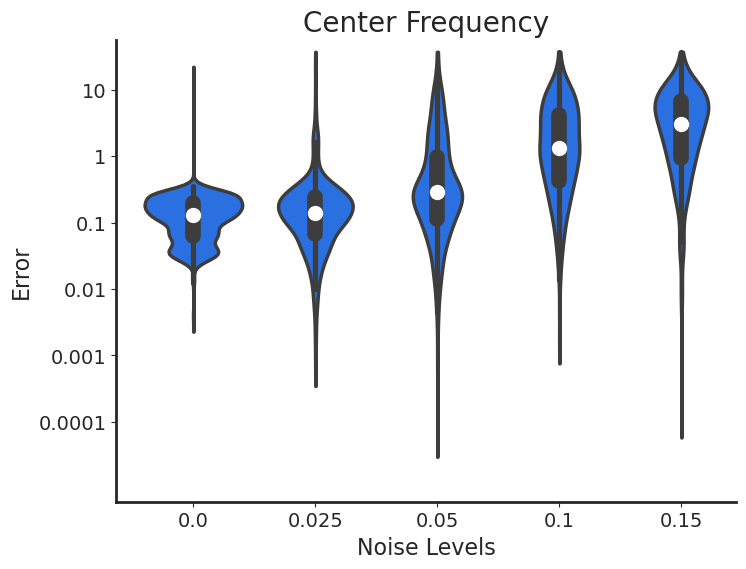

In [46]:
# Plot the error of peak center frequency reconstruction
plot_errors_violin(cf_errors_ourMethod, 'Center Frequency', plt_log=PLT_LOG, 
                   ylim=YLIMS_CF, yticks=YTICKS_CF,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'cf_error'))

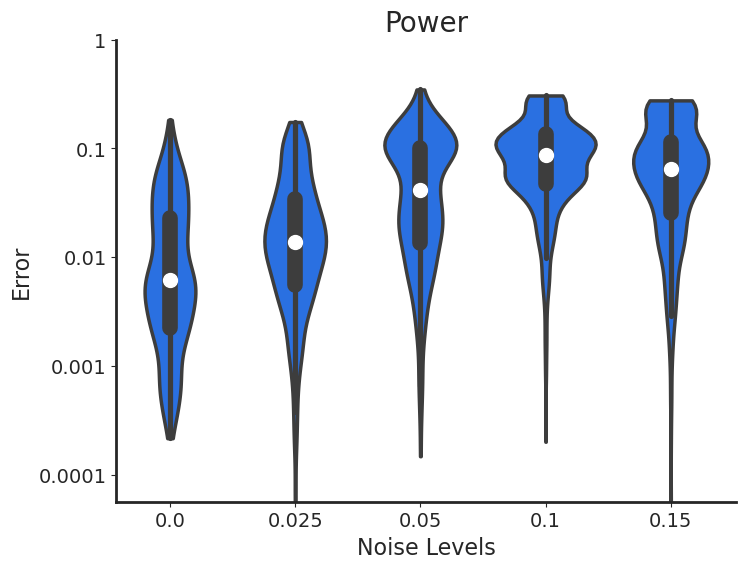

In [47]:
# Plot the error of peak power reconstruction
plot_errors_violin(pw_errors_ourMethod, 'Power', plt_log=PLT_LOG, 
                   ylim=YLIMS_PW, yticks=YTICKS_PW,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'pw_error'))

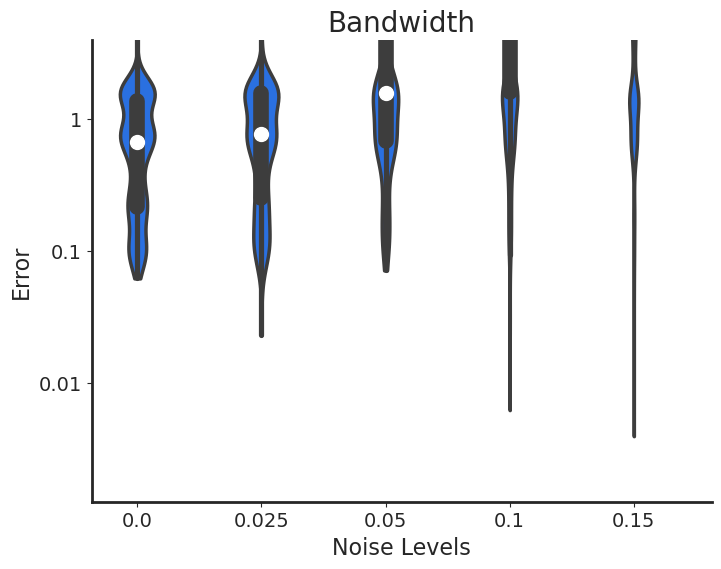

In [48]:
# Plot the error of peak bandwidth reconstruction
plot_errors_violin(bw_errors_ourMethod, 'Bandwidth', plt_log=PLT_LOG,
                   ylim=YLIMS_BW, yticks=YTICKS_BW,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'bw_error'))

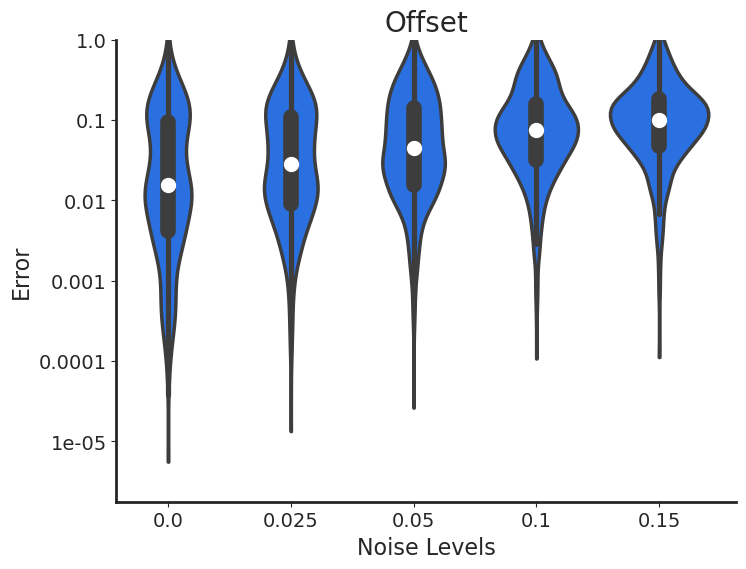

In [49]:
# Plot the error of aperiodic offset reconstruction
plot_errors_violin(off_errors_ourMethod, 'Offset', plt_log=PLT_LOG, ylim=YLIMS_AP,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'off_error'))

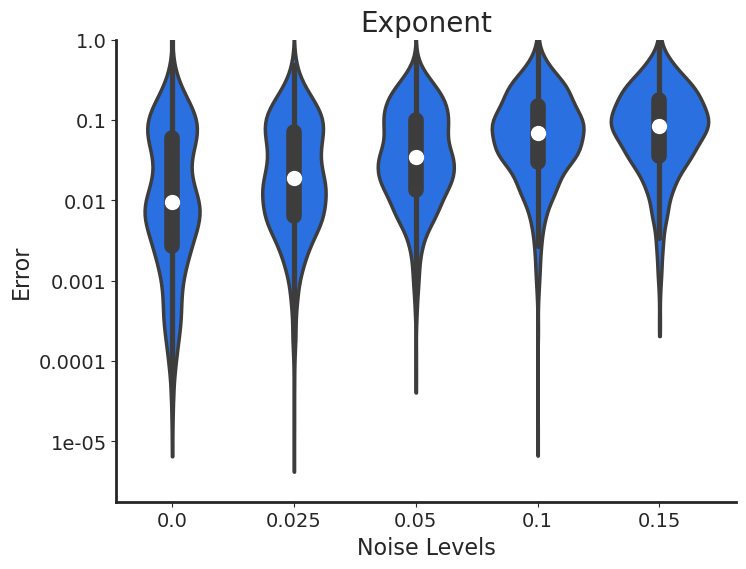

In [50]:
# Plot the error of aperiodic exponent reconstruction
plot_errors_violin(exp_errors_ourMethod, 'Exponent', plt_log=PLT_LOG, ylim=YLIMS_AP,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'exp_error'))

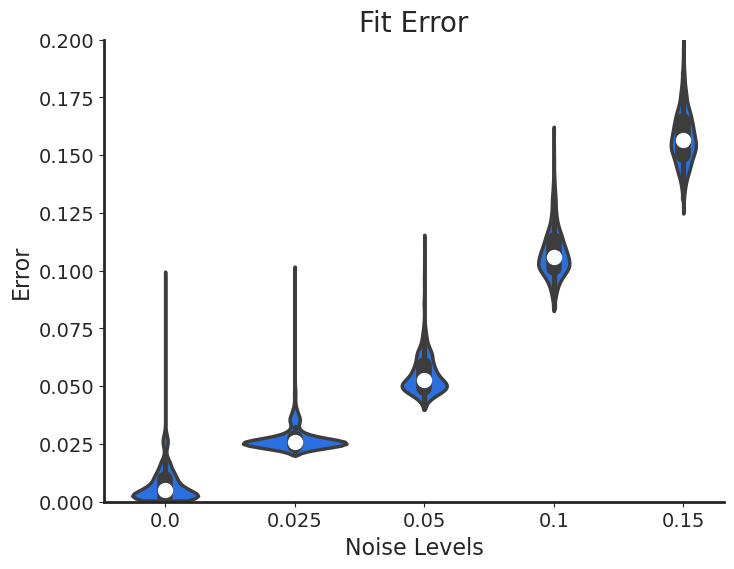

In [51]:
# Plot the amount of error across noise levels
plot_errors_violin(err_fits_ourMethod, 'Fit Error', y_label='Error', plt_log=False, ylim=[0, 0.2],
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'model_error'))

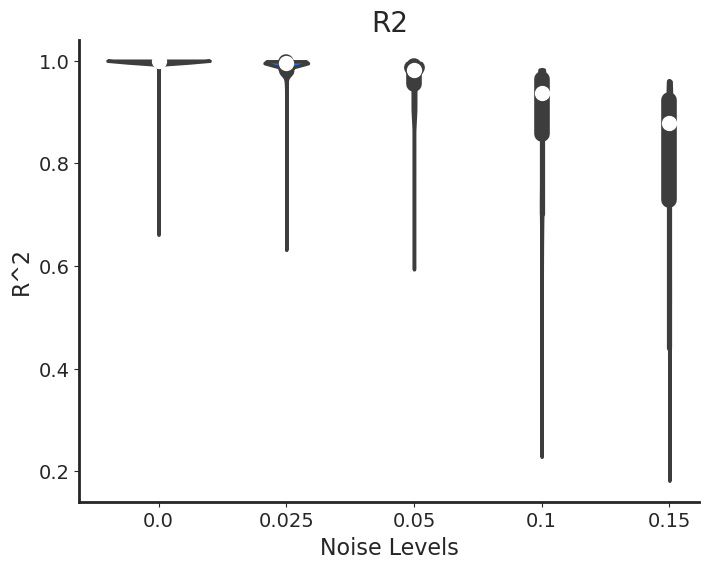

In [52]:
# Plot the goodness-of-fit (R^2) across noise levels
plot_errors_violin(r2_fits_ourMethod, 'R2', y_label='R^2', plt_log=False,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'model_r_squared'))

Now, let's do a subplot:

Center Freq:

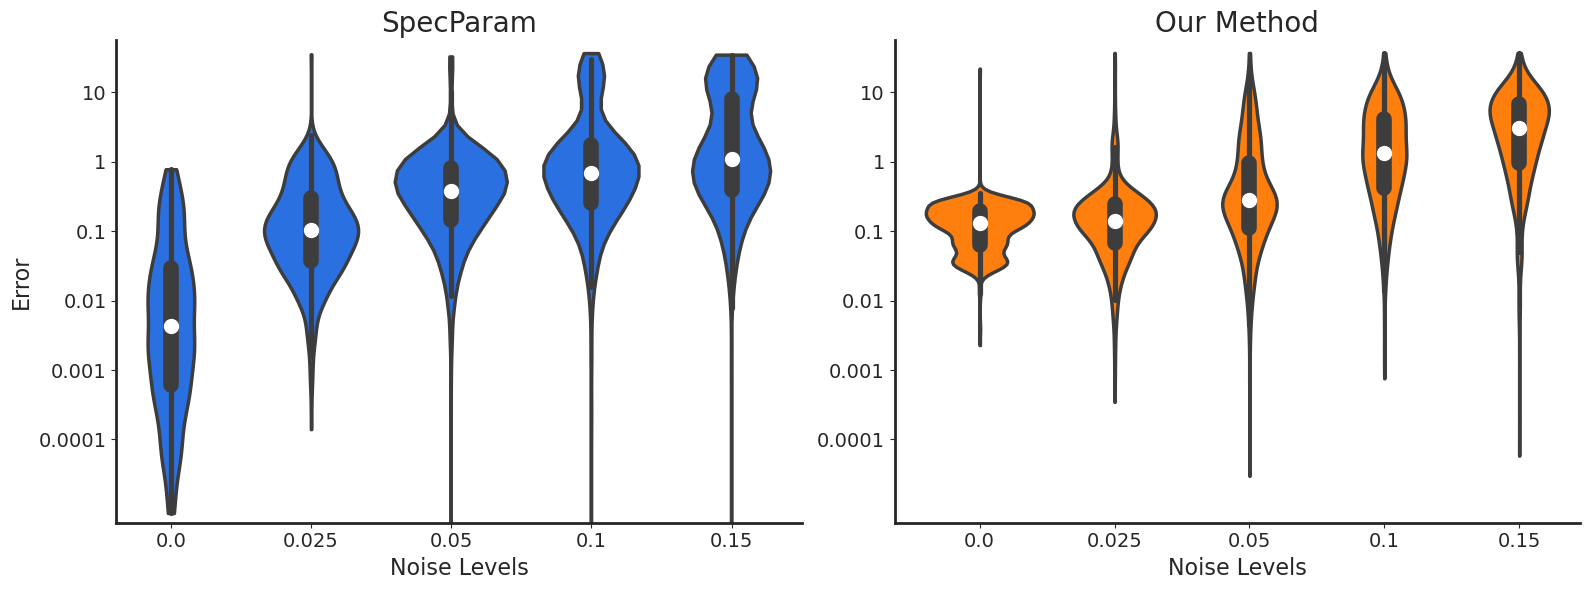

In [53]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# Plot the error of the SpecParam method
plot_errors_violin(cf_errors_SpecParam, 'SpecParam', plt_log=PLT_LOG, ylim=YLIMS_CF, yticks=YTICKS_CF,
                   ax=axs[0], save_fig=False, ifOrange=False)

# Plot the error of our method
plot_errors_violin(cf_errors_ourMethod, 'Our Method', plt_log=PLT_LOG, ylim=YLIMS_CF, yticks=YTICKS_CF,
                   ax=axs[1], save_fig=False, ifOrange=True)

# Optionally adjust layout
plt.tight_layout()

# add a title: Center Frequency
# fig.suptitle('Center Frequency', fontsize=16)


plt.show()


Power:

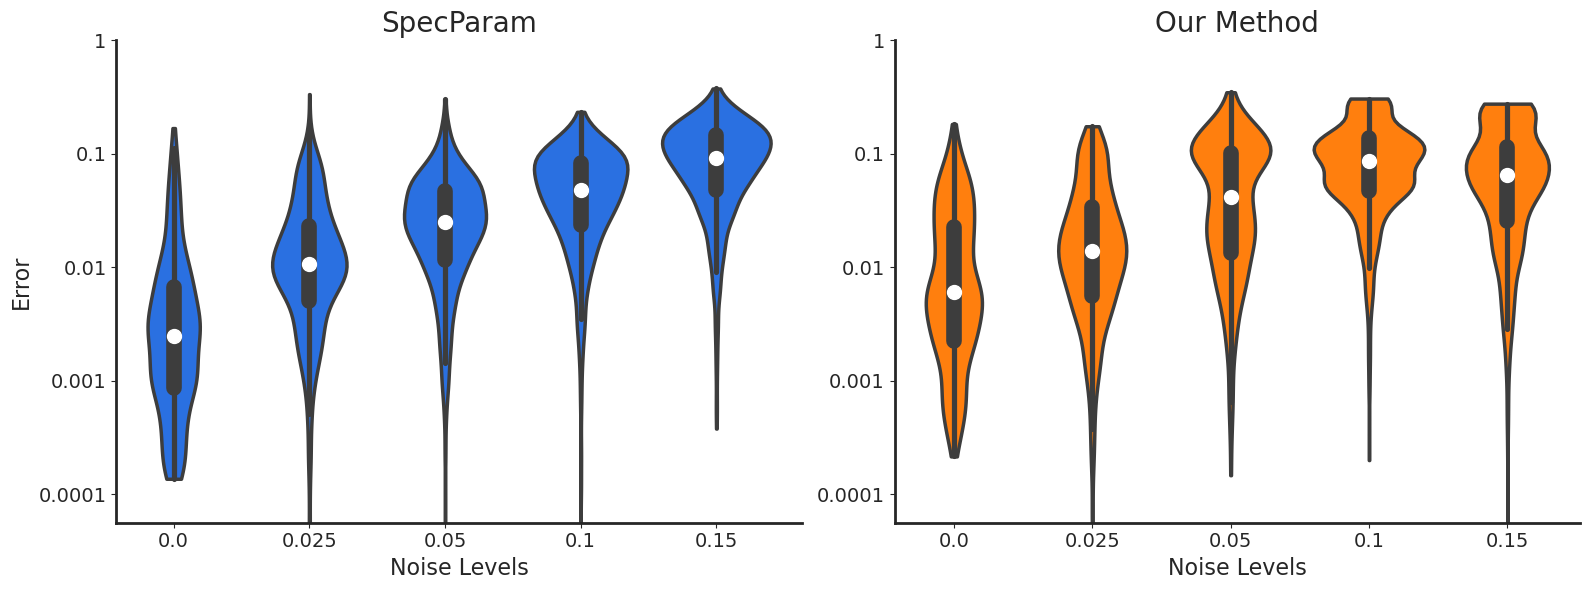

In [54]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# Plot the error of the SpecParam method
plot_errors_violin(pw_errors_SpecParam, 'SpecParam', plt_log=PLT_LOG, ylim=YLIMS_PW, yticks=YTICKS_PW,
                   ax=axs[0], save_fig=False, ifOrange=False)

# Plot the error of our method
plot_errors_violin(pw_errors_ourMethod, 'Our Method', plt_log=PLT_LOG, ylim=YLIMS_PW, yticks=YTICKS_PW,
                   ax=axs[1], save_fig=False, ifOrange=True)

# Optionally adjust layout
plt.tight_layout()


plt.show()

Bandwidth:

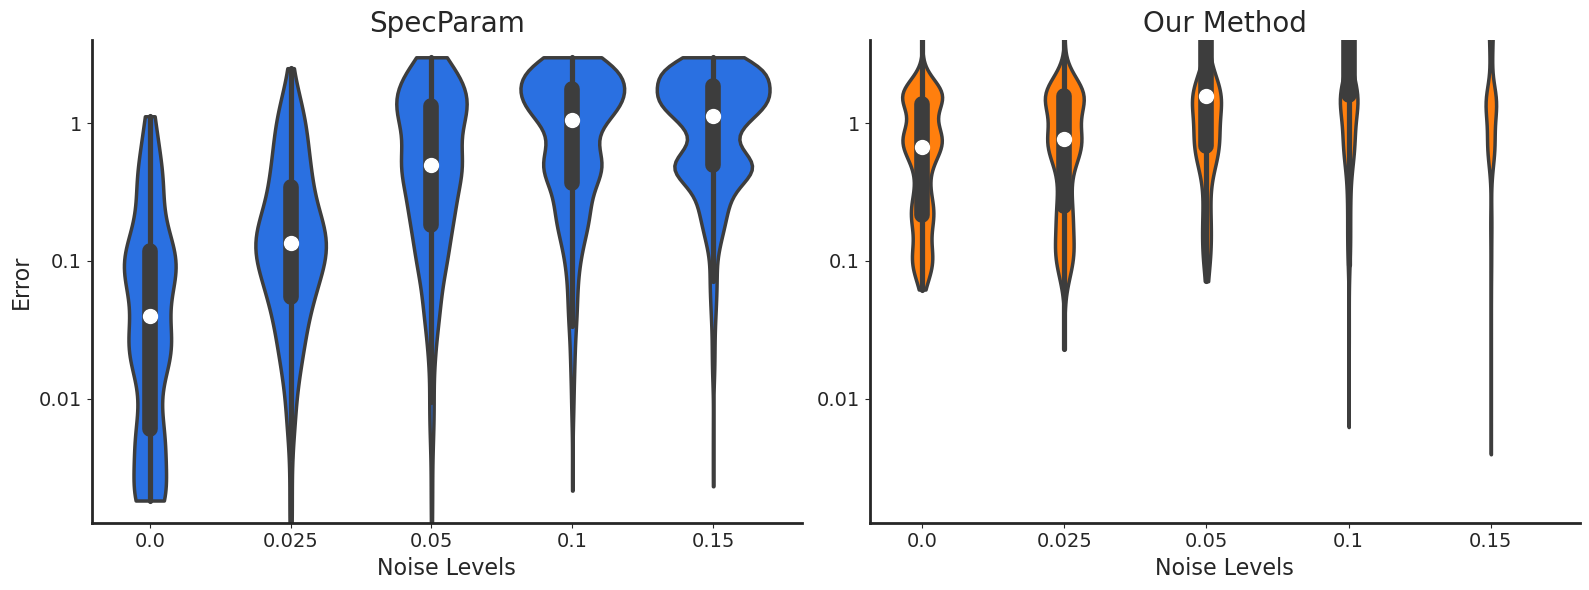

In [55]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# Plot the error of the SpecParam method
plot_errors_violin(bw_errors_SpecParam, 'SpecParam', plt_log=PLT_LOG, ylim=YLIMS_BW, yticks=YTICKS_BW,
                   ax=axs[0], save_fig=False, ifOrange=False)

# Plot the error of our method
plot_errors_violin(bw_errors_ourMethod, 'Our Method', plt_log=PLT_LOG, ylim=YLIMS_BW, yticks=YTICKS_BW,
                   ax=axs[1], save_fig=False, ifOrange=True)

# Optionally adjust layout
plt.tight_layout()


plt.show()

Offset:

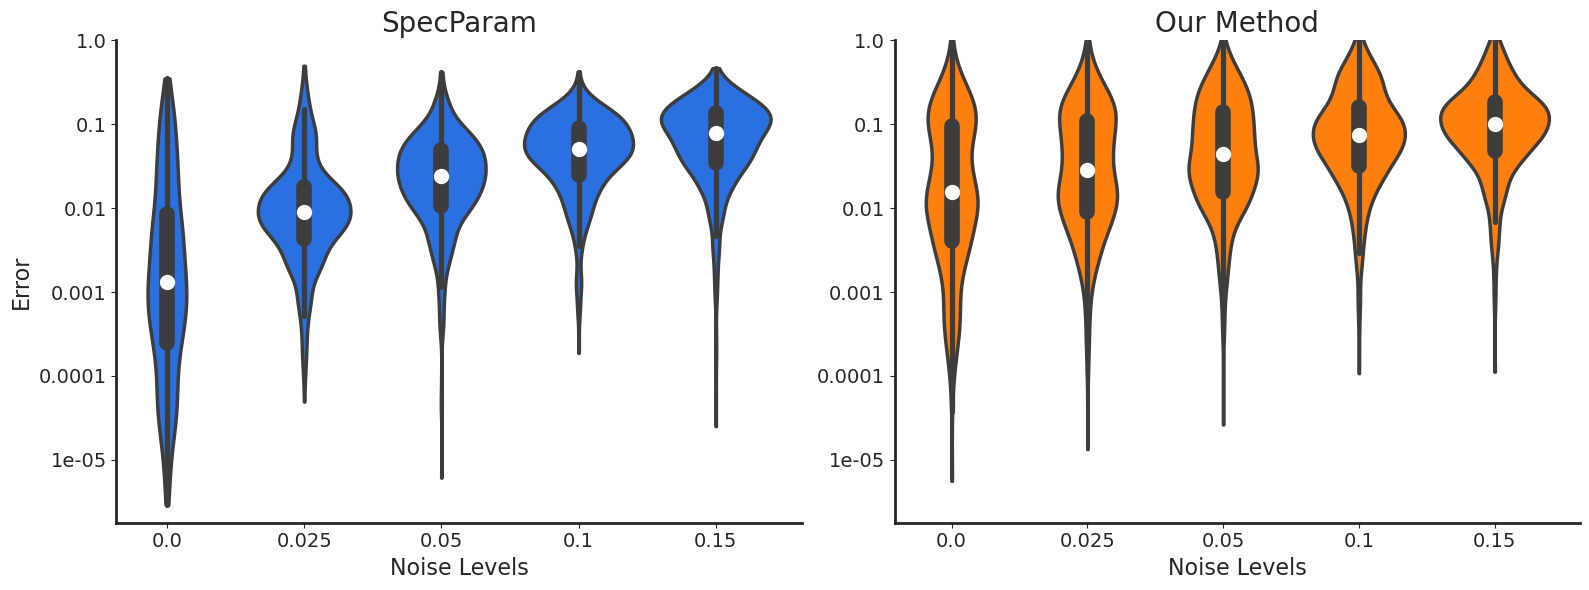

In [56]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# Plot the error of the SpecParam method
plot_errors_violin(off_errors_SpecParam, 'SpecParam', plt_log=PLT_LOG, ylim=YLIMS_AP,
                   ax=axs[0], save_fig=False, ifOrange=False)

# Plot the error of our method
plot_errors_violin(off_errors_ourMethod, 'Our Method', plt_log=PLT_LOG, ylim=YLIMS_AP,
                   ax=axs[1], save_fig=False, ifOrange=True)

# Optionally adjust layout
plt.tight_layout()


plt.show()

Exponent:

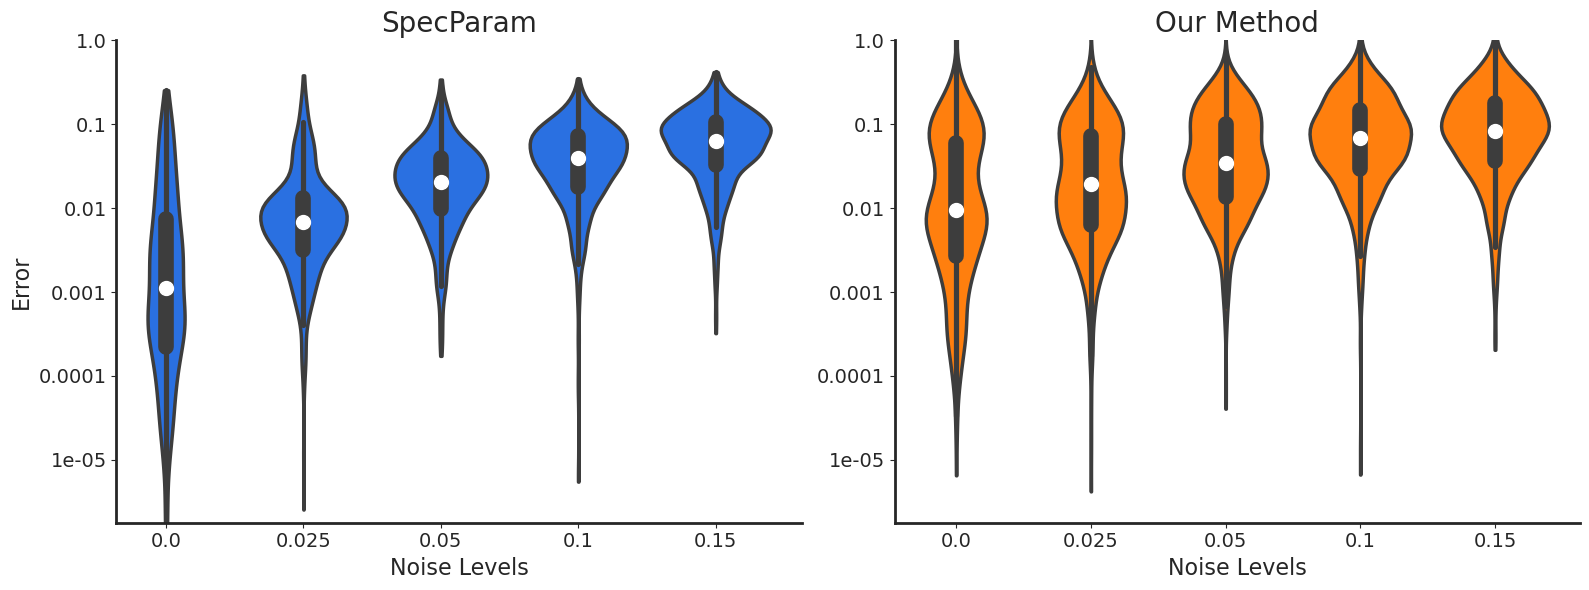

In [57]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# Plot the error of the SpecParam method
plot_errors_violin(exp_errors_SpecParam, 'SpecParam', plt_log=PLT_LOG, ylim=YLIMS_AP,
                   ax=axs[0], save_fig=False, ifOrange=False)

# Plot the error of our method
plot_errors_violin(exp_errors_ourMethod, 'Our Method', plt_log=PLT_LOG, ylim=YLIMS_AP,
                   ax=axs[1], save_fig=False, ifOrange=True)

# Optionally adjust layout
plt.tight_layout()


plt.show()

Overall Fit error:

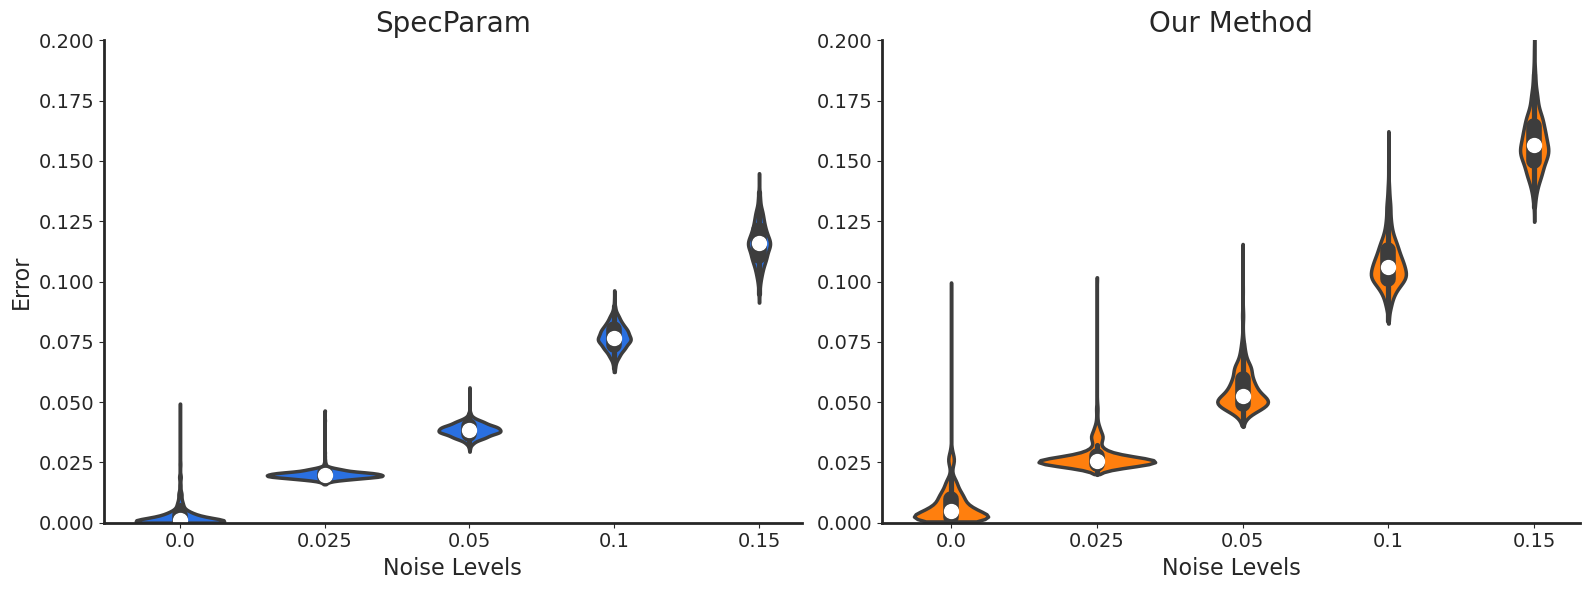

In [58]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # 1 row, 2 columns

# Plot the error of the SpecParam method
plot_errors_violin(err_fits_SpecParam, 'SpecParam', plt_log=False, ylim=[0, 0.2],
                   ax=axs[0], save_fig=False, ifOrange=False)

# Plot the error of our method
plot_errors_violin(err_fits_ourMethod, 'Our Method', plt_log=False, ylim=[0, 0.2],
                   ax=axs[1], save_fig=False, ifOrange=True)

# Optionally adjust layout
plt.tight_layout()


plt.show()

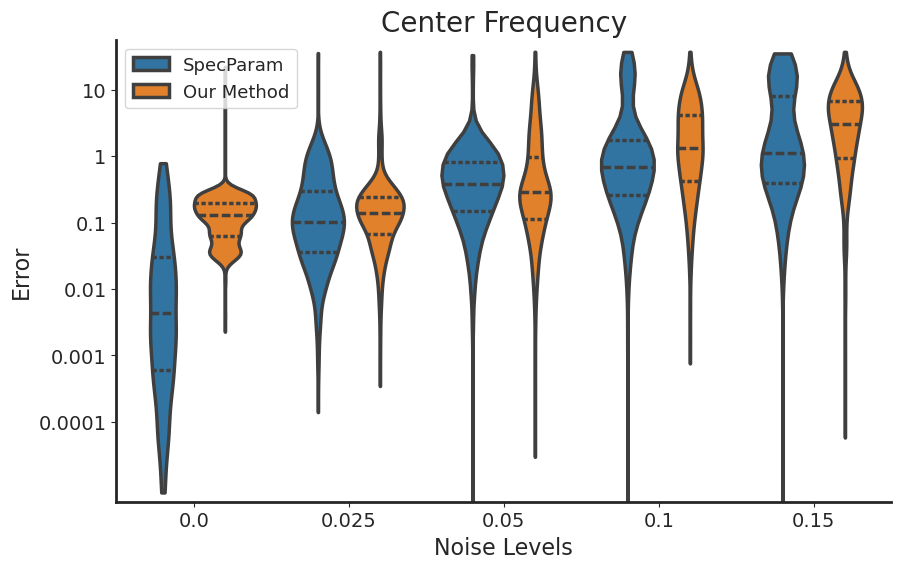

In [59]:
plot_comparison_violin_AT(cf_errors_SpecParam, cf_errors_ourMethod, ['SpecParam', 'Our Method'],
                       title='Center Frequency', plt_log=PLT_LOG, ylim=YLIMS_CF, yticks=YTICKS_CF, save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'cf_error_comparison'))
plt.show()


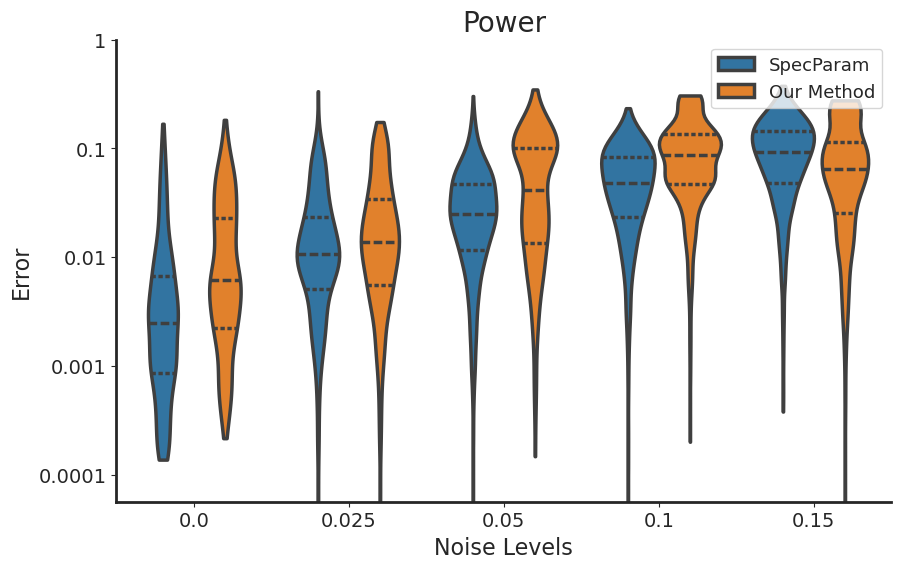

In [60]:
plot_comparison_violin_AT(pw_errors_SpecParam, pw_errors_ourMethod, [ 'SpecParam', 'Our Method'],
                       title='Power', plt_log=PLT_LOG, ylim=YLIMS_PW, yticks=YTICKS_PW, save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'pw_error_comparison'))
plt.show()


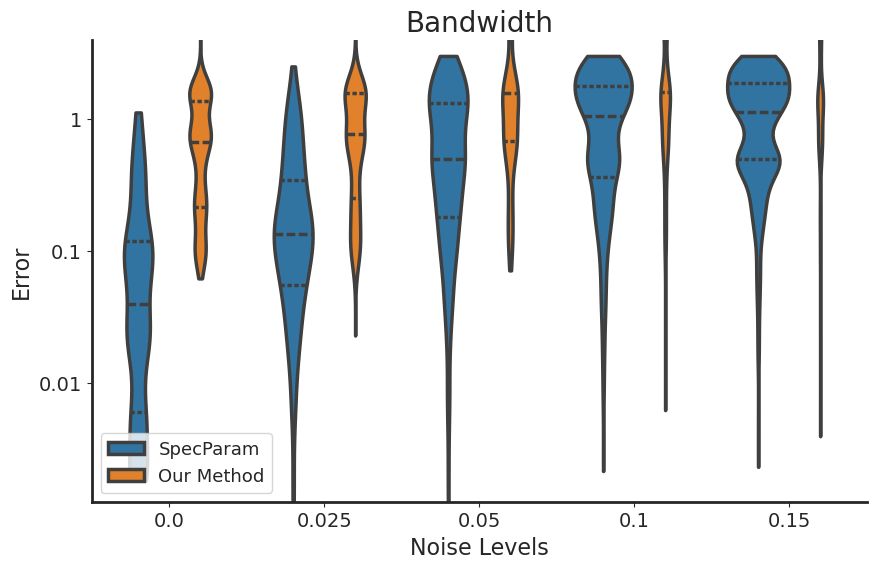

In [61]:
# Plot the error of peak bandwidth reconstruction
plot_comparison_violin_AT(bw_errors_SpecParam, bw_errors_ourMethod, ['SpecParam', 'Our Method'],
                       title='Bandwidth', plt_log=PLT_LOG, ylim=YLIMS_BW, yticks=YTICKS_BW, save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'bw_error_comparison'))
plt.show()


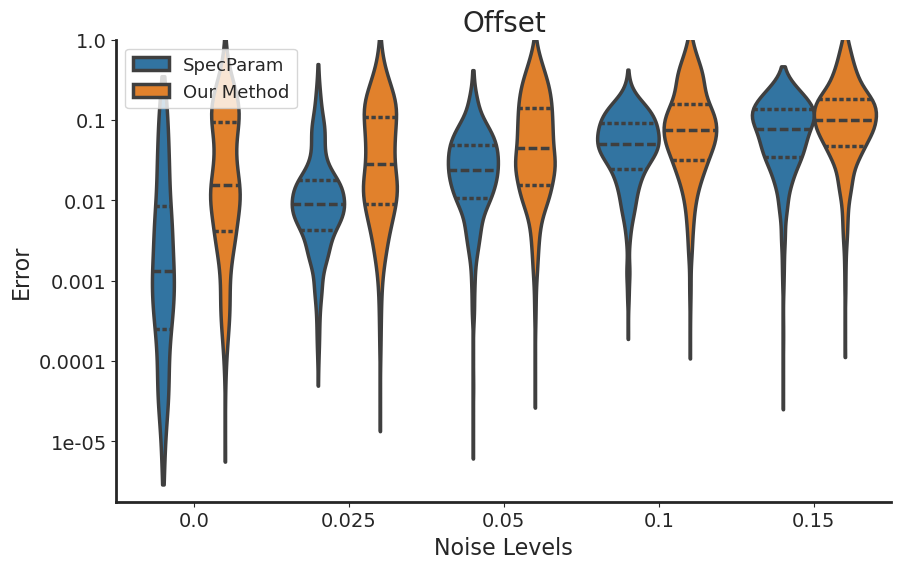

In [62]:
plot_comparison_violin_AT(off_errors_SpecParam, off_errors_ourMethod, ['SpecParam', 'Our Method'],
                       title='Offset', plt_log=PLT_LOG, ylim=YLIMS_AP, save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'off_error_comparison'))
plt.show()

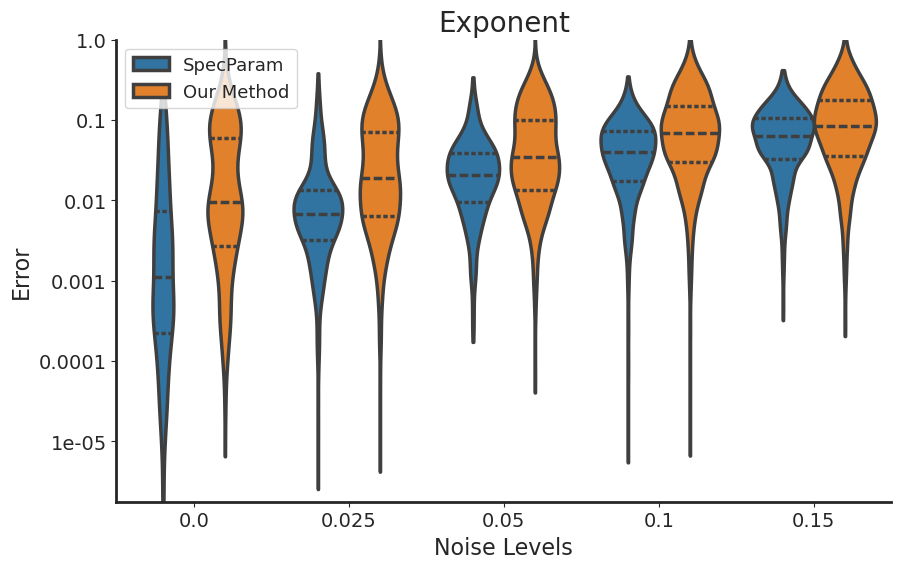

In [63]:
plot_comparison_violin_AT(exp_errors_SpecParam, exp_errors_ourMethod, ['SpecParam', 'Our Method'],
                       title='Exponent', plt_log=PLT_LOG, ylim=YLIMS_AP, save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'exp_error_comparison'))
plt.show()

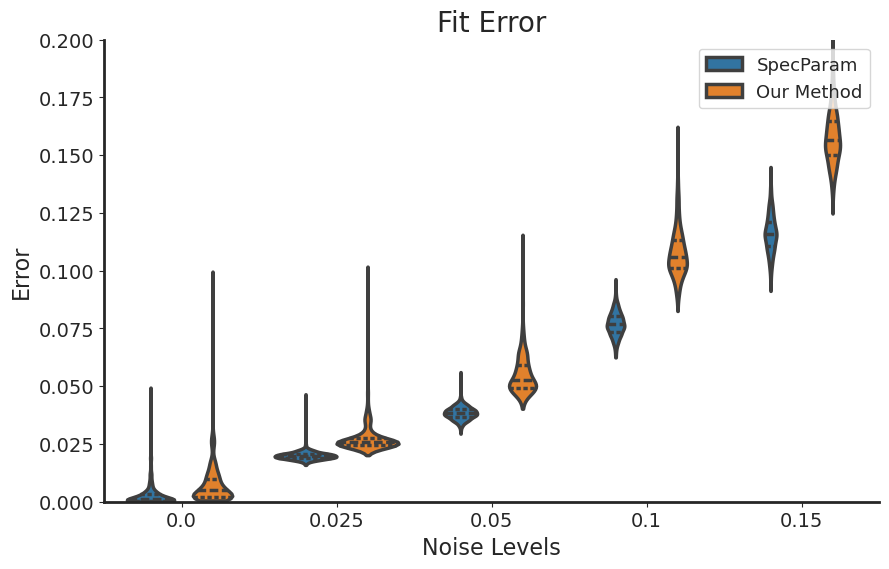

In [64]:
plot_comparison_violin_AT(err_fits_SpecParam, err_fits_ourMethod, ['SpecParam', 'Our Method'],
                       title='Fit Error', y_label='Error', plt_log=False, ylim=[0, 0.2], save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'model_error_comparison'))
plt.show()
